## FloodWater Detection Challenge

_The goal of this challenge is to build machine learning algorithms that are able to map floodwater using Sentinel-1 global SAR imagery_

Introduction to SAR Imagery:

https://www.capellaspace.com/sar-101-an-introduction-to-synthetic-aperture-radar/

Tutorial Adapted from:

https://www.drivendata.org/competitions/81/detect-flood-water/

## Step 0: Download the Data

Option 1: 
https://drive.google.com/drive/folders/1FvGSIn6H-0EVpAEYDVMfvMN5k67wAjcQ?usp=sharing

Option 2:
https://zenodo.org/record/5843280


Unzip and save in your project folder

In [ ]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


External Libraries Required:
1. Pytorch
2. Pytorch Lightning
3. Albumentations
4. Rasterio
5. Pytorch Segmentation Models

In [ ]:
# Uncomment below commands and run once!

!pip install pytorch_lightning
!pip install rasterio
!pip install -U albumentations
!pip install segmentation-models-pytorch
!pip install pandas-path


     |████████████████████████████████| 526 kB 5.3 MB/s 
     |████████████████████████████████| 332 kB 43.2 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 829 kB 42.4 MB/s 
     |████████████████████████████████| 133 kB 44.3 MB/s 
     |████████████████████████████████| 1.1 MB 40.8 MB/s 
     |████████████████████████████████| 160 kB 48.9 MB/s 
     |████████████████████████████████| 271 kB 37.7 MB/s 
     |████████████████████████████████| 192 kB 48.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=b17f3e53573f77ea8aa91fc3346e613e7ca6c6a3f787195fb4381fe0d3a3d5bd
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
# Run these two if the library 'albumentations' throws an error

!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [ ]:
# Set current directory to project folder
import os
os.chdir("/content/drive/MyDrive/AMS_2022_Supervised_DL")

# Check current directory
os.getcwd()

'/content/drive/MyDrive/AMS_2022_Supervised_DL'

In [ ]:
import random
import numpy as np
import pandas as pd
from pandas_path import path
import matplotlib.pyplot as plt
from pathlib import Path

import rasterio

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations

import pytorch_lightning as pl
import segmentation_models_pytorch as smp

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Import Data

In [ ]:
DATA_PATH = Path("/content/drive/MyDrive/AMS_2022_Supervised_DL/training_data")

FEATURE_PATH = DATA_PATH / "train_features"
LABEL_PATH = DATA_PATH / "train_labels"

In [ ]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [ ]:
# Add paths to SAR images and corresponding labels to the metadata

train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,/content/drive/MyDrive/AMS_2022_Supervised_DL/...,/content/drive/MyDrive/AMS_2022_Supervised_DL/...
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,/content/drive/MyDrive/AMS_2022_Supervised_DL/...,/content/drive/MyDrive/AMS_2022_Supervised_DL/...
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,/content/drive/MyDrive/AMS_2022_Supervised_DL/...,/content/drive/MyDrive/AMS_2022_Supervised_DL/...
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,/content/drive/MyDrive/AMS_2022_Supervised_DL/...,/content/drive/MyDrive/AMS_2022_Supervised_DL/...
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,/content/drive/MyDrive/AMS_2022_Supervised_DL/...,/content/drive/MyDrive/AMS_2022_Supervised_DL/...


## 2. Exploratory Analysis

In [ ]:
# Exploratory Analysis

# Check no. of unique images
print(train_metadata.chip_id.nunique())


542


In [ ]:
# No. of floods and images(chips) per flood event

flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

Text(0.5, 1.0, 'Number of Chips by Location')

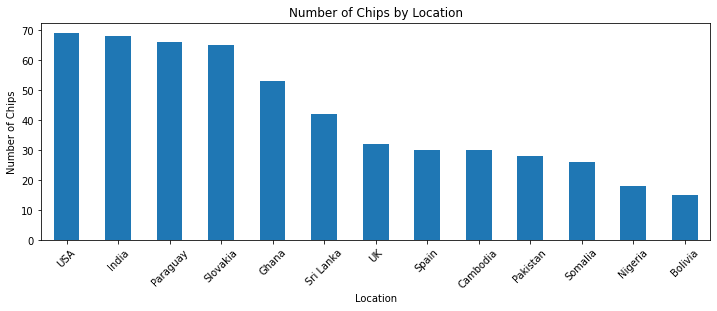

In [ ]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

In [ ]:
# Examine an sample image

image_path = train_metadata.feature_path[0]

with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

In [ ]:
metadata

{'count': 1,
 'crs': CRS.from_epsg(32720),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 512,
 'nodata': 0.0,
 'transform': Affine(10.0, 0.0, 314030.0,
       0.0, -10.0, 8585890.0),
 'width': 512}

In [ ]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [ ]:
data.shape

(512, 512)

In [ ]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)
    

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)
        
    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

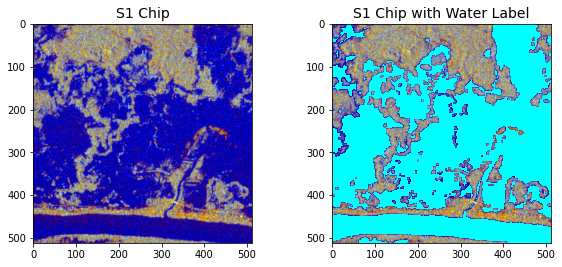

In [ ]:
# Display a random sample image

display_random_chip(12)


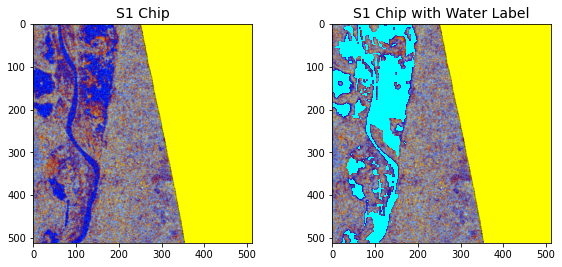

In [ ]:
display_random_chip(90)

## 3. Training and Validation Dataset

In [ ]:
random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [ ]:
# Validation dataset
val_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]

# Training dataset
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [ ]:
# Confirm approx. 1/3 of chips are in the validation set
len(val_df) / (len(val_df) + len(train_df)) * 100

32.47232472324723

## 4. Building a Flood Segmentation Model

Pyotch requires the following:

1. Dataset class
2. Transformations (if applicable)
3. Loss function
4. Model
5. Optimizer

In [ ]:
# Define a Torch Dataset Class

class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, metadata, feature_dir, label_dir=None, transforms=None):
        self.chip_ids = metadata.chip_id.tolist()
        self.feature_dir = feature_dir
        self.label_dir = label_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip_id
        chip_id = self.chip_ids[idx]
        vv_path = self.feature_dir / f"{chip_id}_vv.tif"
        vh_path = self.feature_dir / f"{chip_id}_vh.tif"
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label_dir is not None:
            label_path = self.label_dir / f"{chip_id}.tif"
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentations to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr

        return sample

In [ ]:
# These transformations will be passed to our dataset and model
training_transformations = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [ ]:
# Define the Loss Function

class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where(~valid_pixel_mask, 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

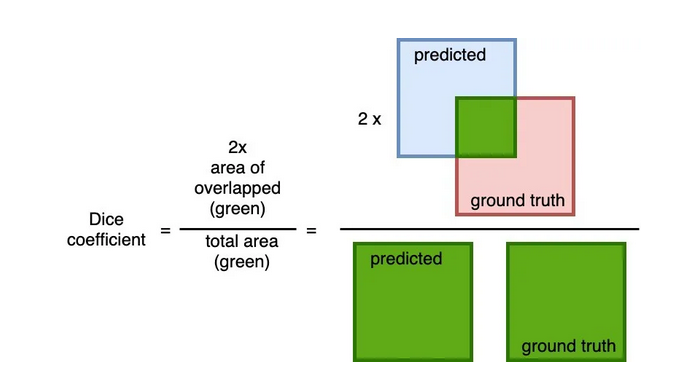

In [ ]:
# Validation metric to test your model performance

def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

## UNet Model

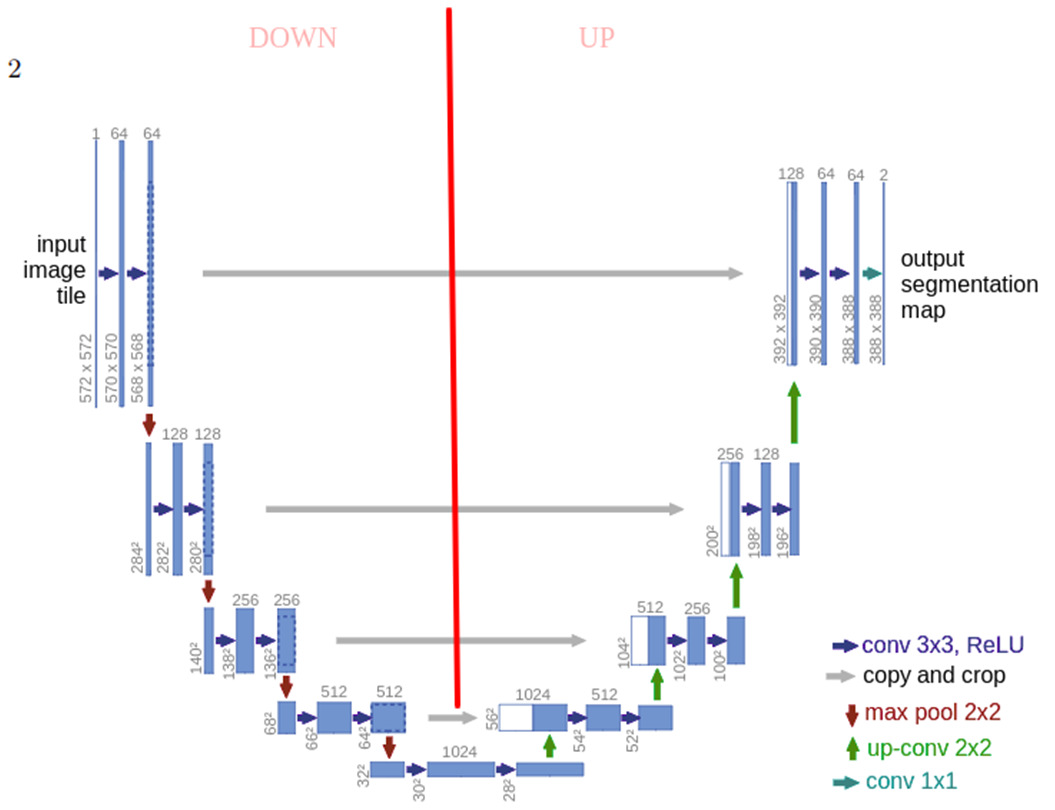

In [ ]:
# Main Model

class FloodModel(pl.LightningModule):
    def __init__(self, train_metadata, val_metadata, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.feature_dir = self.hparams.get("feature_dir")
        self.label_dir = self.hparams.get("label_dir")
        self.train_chip_ids = self.hparams.get("train_chip_ids")
        self.val_chip_ids = self.hparams.get("val_chip_ids")
        self.transform = training_transformations
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.fast_dev_run = self.hparams.get("fast_dev_run", False)
        self.val_sanity_checks = self.hparams.get("val_sanity_checks", 0)
        self.gpu = self.hparams.get("gpu", False)
        
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model_outputs")
        self.output_path.mkdir(exist_ok=True)
        self.log_path = Path.cwd() / hparams.get("log_path", "tensorboard_logs")
        self.log_path.mkdir(exist_ok=True)
        
        # Instantiate training and val datasets
        self.train_dataset = self._build_df(train_metadata, group="train")
        self.val_dataset = self._build_df(val_metadata, group="val")

        # Instantiate model and trainer params
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0


    ## Required LightningModule methods ##


    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss", xe_dice_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )
        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler, "interval": "epoch", "monitor": "iou_epoch",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

    
    ## Convenience Methods ##


    def _build_df(self, metadata, group):
        # Instantiate datasets
        if group == "train":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    label_dir=self.label_dir,
                    transforms=self.transform
            )
        elif group == "val":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    label_dir=self.label_dir,
                    transforms=None
            )
        return df
    
    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=2,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="iou_epoch",
            mode="max",
            verbose=True,
        )
        # Define early stopping behavior
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="iou_epoch",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )
        # Specify where TensorBoard logs will be saved
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")
        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.fast_dev_run,
            "num_sanity_val_steps": self.val_sanity_checks,
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

In [ ]:
hparams = {
    # Required hparams
    "feature_dir": FEATURE_PATH,
    "label_dir": LABEL_PATH,
    # Optional hparams
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 1000,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 2,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model_outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

In [ ]:
flood_model = FloodModel(train_metadata=train_df, val_metadata=val_df, hparams=hparams)
# flood_model.fit()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# Check your best score so far

flood_model.trainer_params["callbacks"][0].best_model_score

In [ ]:
# Generate predictions!

model = flood_model

model.eval()
intersection = 0
union = 0

batch_size = hparams.get("batch_size")

valloader = model.val_dataloader()
val_true = torch.zeros(batch_size,512,512).cuda()
val_preds = torch.zeros(batch_size,512,512).cuda()

with torch.no_grad():
    for i, valdata in enumerate(valloader):
        inpts = valdata["chip"]
        lbls = valdata["label"]

        inpts = inpts.to(device)
        lbls = lbls.to(device)
        lbls = lbls.long()
        
        valpreds = model(inpts)
        valpreds = torch.softmax(valpreds, dim=1)[:, 1]
        valpreds = (valpreds > 0.5) * 1
        
        # Save results
        val_preds = torch.vstack((val_preds, valpreds))
        val_true = torch.vstack((val_true, lbls))      
        
        i, u = intersection_and_union(valpreds, lbls)
        intersection += i
        union += u


# Remove the initial empty tensor
val_preds = val_preds[batch_size:].cpu().numpy()
val_true = val_true[batch_size:].cpu().numpy()




In [ ]:
# Saved Results

# Download from here:
# https://drive.google.com/drive/folders/1y7TFfkFdSN5_kUhDyGkka_Xq2YYxV8q-?usp=sharing


val_preds_unet, val_true_unet = torch.load("val_results/val_results_unet.pt")
val_preds_unetpp, val_true_unetpp = torch.load("val_results/val_results_unet++.pt")

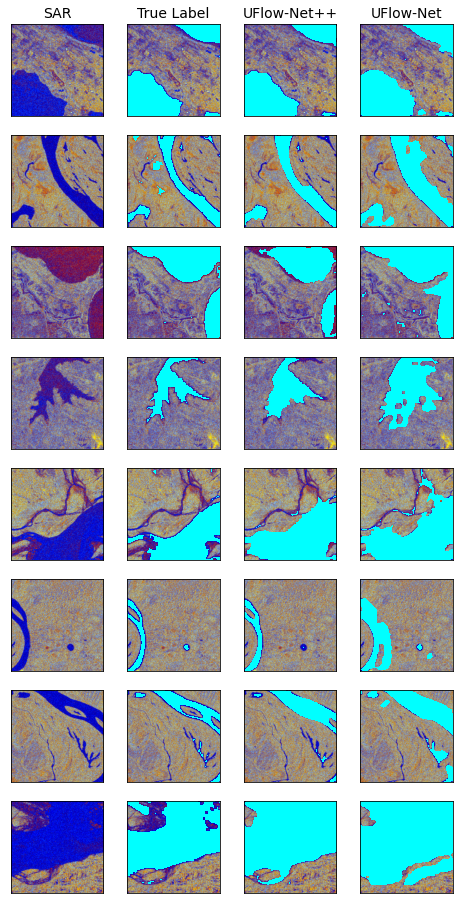

In [ ]:
# Plot

imgs = [175, 32, 169, 151, 93, 45, 37, 76]

fig, ax = plt.subplots(8,4, 
                       figsize=(8,16))
                      

for i, idx in enumerate(imgs):
    
    vv_path = val_df[val_df.polarization == "vv"].feature_path.values[idx]
    vh_path = val_df[val_df.polarization == "vh"].feature_path.values[idx]

    # Create false color composite
    val_img = create_false_color_composite(vv_path, vh_path)
    
    # Get true labels
    label_path = val_df.label_path.values[2*idx]
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)
        
    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)
    
    # Predicted lalels
    pred_unet = val_preds_unet[idx]
    pred_unet = np.ma.masked_where((pred_unet == 0) | (pred_unet == 255), pred_unet)
    
    pred_unetpp = val_preds_unetpp[idx]
    pred_unetpp = np.ma.masked_where((pred_unetpp == 0) | (pred_unetpp == 255), pred_unetpp)
    
    
    # Plot
    ax[i,0].imshow(val_img)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    
    ax[i,1].imshow(val_img)
    ax[i,1].imshow(label, cmap="cool", alpha=1.0)
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    
    ax[i,2].imshow(val_img)
    ax[i,2].imshow(pred_unet, cmap="cool", alpha=1.0)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    
    ax[i,3].imshow(val_img)
    ax[i,3].imshow(pred_unetpp, cmap="cool", alpha=1.0)
    ax[i,3].set_xticks([])
    ax[i,3].set_yticks([])
    
    
ax[0,0].set_title("SAR", fontsize=14)
ax[0,1].set_title("True Label", fontsize=14)  
ax[0,2].set_title("UFlow-Net++", fontsize=14)  
ax[0,3].set_title("UFlow-Net", fontsize=14)  

plt.show()

## Excercise

1. Experiment with hyperparameters and examine how results change. 
2. How learning rate and batch size are related to each other? 
3. Calculate precision, recall and F1-score 
4. What other data can be used as an input to improve model performance? 